In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os 
import sys
sys.path.append(os.path.abspath('..'))

In [59]:
def preprocess_weather(df):
    """ 
    Scales the weather data and extracts the relevant time interval.
    Keeps only neccessary columns.
    """
     # Convert the column to datetime format
    df["validdate"] = pd.to_datetime(df["validdate"])
    df['datetime'] = df['validdate'].dt.strftime('%Y-%m-%d %H:%M:%S')

    # Extract the date and time components into separate columns
    df["time"] = df["validdate"].dt.strftime("%H:%M")
    # keep only values where time is between 08:00 and 16:00
    df = df[(df['time'] >= '08:00') & (df['time'] <= '15:00')]
    df = df.drop(columns=['validdate', 'time'], axis=1)

    # standardise the data
    df['global_rad:W'] = (df['global_rad:W'] - df['global_rad:W'].mean()) / df['global_rad:W'].std()
    df['diffuse_rad:W'] = (df['diffuse_rad:W'] - df['diffuse_rad:W'].mean()) / df['diffuse_rad:W'].std()
    df['effective_cloud_cover:octas'] = (df['effective_cloud_cover:octas'] - df['effective_cloud_cover:octas'].mean()) / (df['effective_cloud_cover:octas'].std())
    df['relative_humidity_2m:p'] = (df['relative_humidity_2m:p'] - df['relative_humidity_2m:p'].mean()) / (df['relative_humidity_2m:p'].std())
    df['t_2m:C'] = (df['t_2m:C'] - df['t_2m:C'].mean()) / (df['t_2m:C'].std())

    return df

def load_weather_data():
    # get path to directory
    current_directory = os.getcwd().split("Dissertation")[0] + 'pv_data/weather_data'
    # get list of files in directory
    files = os.listdir(current_directory)
    # remove DS_Store file
    files.pop(0)
    # sort files
    files.sort()

    df_dict = {}
    for file in files:
        path_to_file = os.path.join(current_directory, file)
        df = pd.read_csv(path_to_file, sep=';')
        df = preprocess_weather(df)
        df_dict[file] = df
    
    return df_dict    

In [60]:
df_dict = load_weather_data()

In [61]:
df_list = [df for df in df_dict.values()]
df_weather = pd.concat(df_list, axis=0)

In [2]:
# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 400
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_SYSTEMS = 500
# create a tuple of 4 coordinates that form a polygon in the uk

POLY_COORDS = ((50, -6), (50.5, 1.9), (57.6, -5.5), (58, 1.9))

In [63]:
generator = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    coords=POLY_COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv',
                    distance_method='poly',
                    drop_nan=False)

==> Loading data
==> Loaded data in: 0 m : 5 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [74]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

In [75]:
df_pv = generator.pv_series
df_pv['month'] = df_pv['datetime'].dt.month
df_pv['season'] = df_pv['datetime'].dt.month.apply(lambda x: get_season(x))
df_pv = df_pv.drop(['epoch', 'farm'], axis=1)

In [77]:
def merge_weather_and_pv(df_weather, df_pv):
    # Convert 'datetime' columns to datetime type if not already done
    df_pv['datetime'] = pd.to_datetime(df_pv['datetime'])
    df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])

    # get the data in df_pv that has the latitude longitude pairs from unique_coords
    unique_coords = df_weather[['lat', 'lon']].drop_duplicates()
    merged_dataframes = []

    for index, row in unique_coords.iterrows():
        lat, lon = row['lat'], row['lon']
        pv_test = df_pv[(df_pv['latitude'] == lat) & (df_pv['longitude'] == lon)]
        weather_test = df_weather[(df_weather['lat'] == lat) & (df_weather['lon'] == lon)]
       # weather_test = weather_test.drop(['lat', 'lon'], axis=1)

        # Merge the two data frames on the 'datetime' column
        merged_df = weather_test.merge(pv_test, on='datetime')
        # drop nan values if any by row
        merged_df = merged_df.dropna(axis=0)
        merged_dataframes.append(merged_df)

    # Concatenate all the merged data frames into a single data frame
    final_merged_df = pd.concat(merged_dataframes, ignore_index=True)
    
    return final_merged_df



In [78]:
df = merge_weather_and_pv(df_weather=df_weather, df_pv=df_pv)

(2916, 14)
(2898, 14)
(2917, 14)
(2829, 14)
(2901, 14)
(2907, 14)
(2913, 14)
(2901, 14)
(2906, 14)
(2916, 14)
(2778, 14)
(2900, 14)
(2902, 14)
(2832, 14)
(2827, 14)
(2909, 14)
(2784, 14)
(2896, 14)
(2780, 14)
(2911, 14)
(2839, 14)
(2911, 14)
(2893, 14)
(2706, 14)
(2901, 14)
(2894, 14)
(2909, 14)
(2912, 14)
(2799, 14)
(2912, 14)
(2908, 14)
(2502, 14)
(2884, 14)
(2888, 14)
(2896, 14)
(2888, 14)
(2729, 14)
(2854, 14)
(2882, 14)
(2877, 14)
(2914, 14)
(2859, 14)
(2902, 14)
(2894, 14)
(2906, 14)
(2846, 14)
(2873, 14)
(2695, 14)
(2912, 14)
(2911, 14)
(2900, 14)
(2564, 14)
(2897, 14)
(2892, 14)
(2905, 14)
(2880, 14)
(2841, 14)
(2867, 14)
(0, 14)
(2885, 14)
(2551, 14)
(2809, 14)
(2584, 14)
(2884, 14)
(2893, 14)
(2909, 14)
(2908, 14)
(2911, 14)
(2910, 14)
(2903, 14)
(2821, 14)
(2855, 14)
(2845, 14)
(2900, 14)
(2900, 14)
(2913, 14)
(2794, 14)
(2897, 14)
(2779, 14)
(2913, 14)
(2554, 14)
(2907, 14)
(2886, 14)
(2843, 14)
(2812, 14)
(2902, 14)
(2770, 14)
(2895, 14)
(2898, 14)
(2798, 14)
(2905, 14)
(2

In [79]:
unique_coords = df[['latitude', 'longitude']].drop_duplicates().values
len(unique_coords)

248

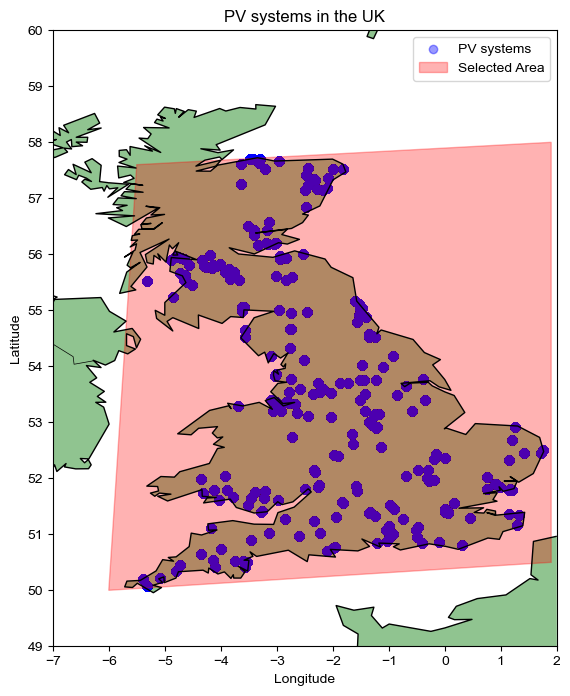

In [80]:
plot_grid(df, POLY_COORDS, distance_method='poly')

In [81]:
from data.utils import save_csv
save_csv(df, folder_name='pv_data', file_name='pv_and_weather.csv')

In [29]:
# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 20
MINUTE_INTERVAL = 60
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_SYSTEMS = 500
# create a tuple of 4 coordinates that form a polygon in the uk
# and a circle with a radius of r
CIRCLE_COORDS = (55, -1.5)
RADIUS = 0.3
POLY_COORDS = ((50, -6), (50.5, 1.9), (57.6, -5.5), (58, 1.9))


In [30]:
from data import PVWeatherLoader

loader = PVWeatherLoader(
    # number of days to get data for
    n_days=N_DAYS,
    # initial day of the data for that season
    # look at the data frame to see which day it is
    day_init=DAY_INIT,
    # number of systems to extract
    n_systems=N_SYSTEMS,
    coords=CIRCLE_COORDS,
    radius=RADIUS,
    # the minute interval our data is sampled at 
    # (e.g. 60 for hourly, 30 for half hourly, 15 for 15 minutes, etc.)
    minute_interval=MINUTE_INTERVAL,
    # the minimum and maximum hour of the day to use
    # (e.g. 8 and 15 for 8am to 3pm)
    day_min=DAY_MIN,
    day_max=DAY_MAX,
    folder_name='pv_data',
    file_name='pv_and_weather.csv',
    distance_method='circle',
    # optionally use a season
    season='winter',
    # optionally drop series with nan values
    drop_nan=False
)

==> Loading data
==> Loaded data in: 0 m : 1 sec



/Users/eirikbaekkelund/Desktop/UCL/Code/Dissertation/data/utils.py:544: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('season', axis=1, inplace=True)


# Examples of using the Weather Loader

In [31]:
# looping through each individual system
# with the specifications made above
for X, y in loader:
    print(X.shape, y.shape)
    

(160, 5) (160,)
(160, 5) (160,)
(160, 5) (160,)
(160, 5) (160,)
(160, 5) (160,)
(160, 5) (160,)
(160, 5) (160,)
(160, 5) (160,)


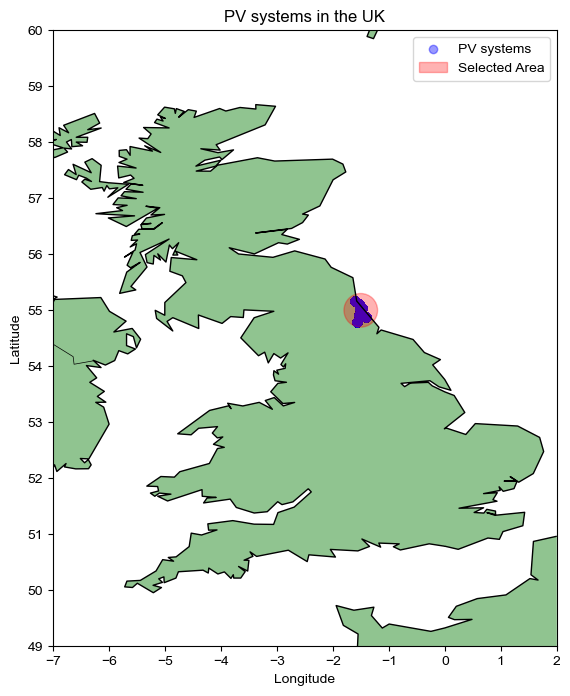

In [34]:
# getting the dataframe
from pv_plot import plot_grid
df = loader.df
plot_grid(df, coords=CIRCLE_COORDS, radius=RADIUS, distance_method='circle')

In [71]:
import torch

X, y = next(iter(loader))
X = torch.tensor(X, dtype=torch.float64)
y = torch.tensor(y, dtype=torch.float64)

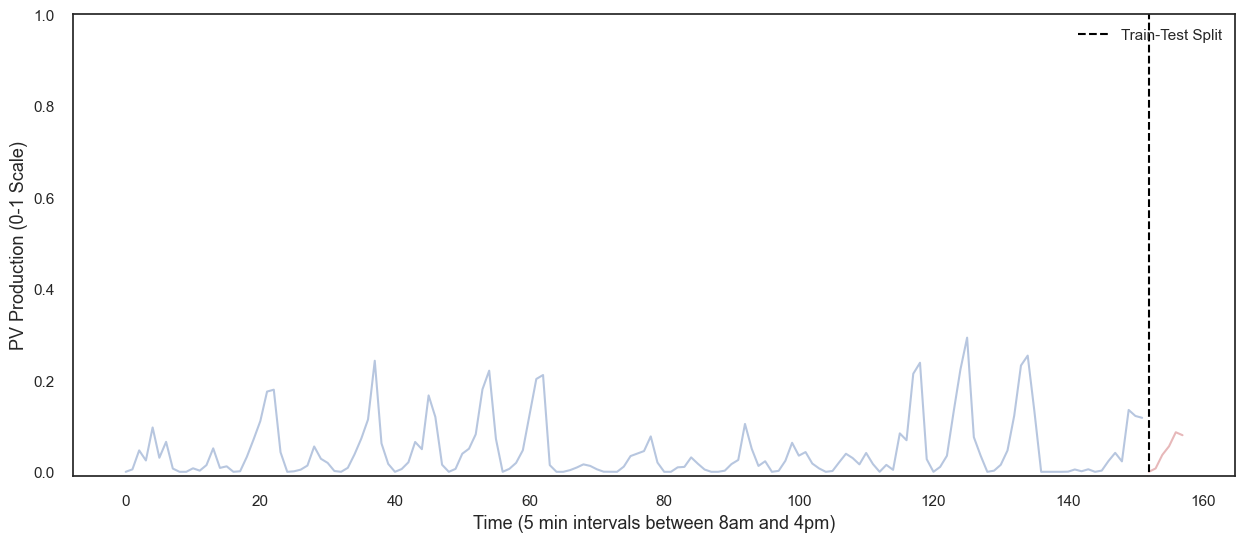

In [72]:
import torch
from data.utils import train_test_split
from pv_plot import plot_train_test_split

X, y = next(iter(loader))

# min max scale X to be between 0 and 1
X = (X - X.min()) / (X.max() - X.min())

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
x_train, y_train, x_test, y_test = train_test_split(X, y, hour=12, minute_interval=60, day_min=8, day_max=15, n_hours=6)
plot_train_test_split(y_train, y_test)

In [73]:
X.shape, y.shape

(torch.Size([160, 5]), torch.Size([160]))

In [75]:
from gpytorch.means import ZeroMean
from gpytorch.constraints import Interval, Positive
from kernels import Kernel

mean = ZeroMean()

kernel = Kernel()
matern_base = kernel.get_matern(lengthscale_constraint=Positive(),
                                outputscale_constraint=Positive())
matern_quasi = kernel.get_matern(lengthscale_constraint=Positive(),
                                 outputscale_constraint=Positive())
periodic1 = kernel.get_periodic(lengthscale_constraint= Positive(),
                                outputscale_constraint=Positive())
periodic2 = kernel.get_periodic(lengthscale_constraint= Positive(),
                                outputscale_constraint=Positive()
                                )

kernel = kernel.get_quasi_periodic(matern_base=matern_base, 
                                    matern_quasi=matern_quasi,
                                    periodic1=periodic1,
                                    periodic2=None)

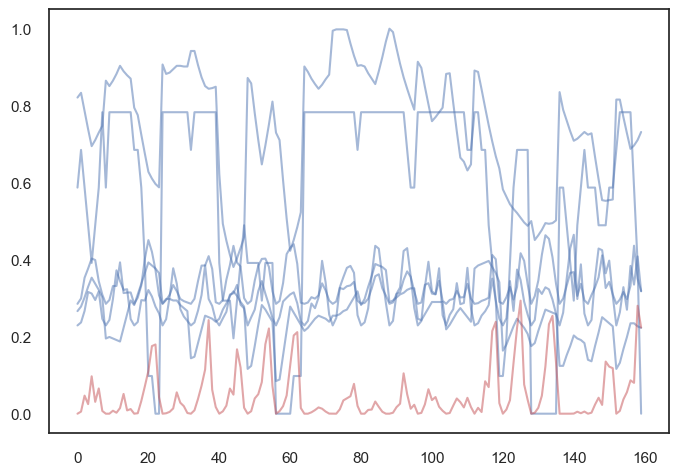

In [76]:
plt.plot(X, color='b', alpha=0.5, label='X')
plt.plot(y, color='r', alpha=0.5, label='y')

In [77]:
from pv_plot.plotting import plot_gp_ax
from likelihoods import BetaLikelihood_MeanParametrization
from models import ApproximateGPBaseModel
from gpytorch.means import ConstantMean, ZeroMean

jitter = 1e-4

config = {  'type': 'stochastic',
            'name': 'mean_field',
            'num_inducing_points': x_train.size(0),
            }
inputs ={
    'X' : x_train,
    'y' : y_train,
    'config': config,
    'jitter': jitter,
    'likelihood': BetaLikelihood_MeanParametrization(scale=30),
    'mean_module': mean,
    'covar_module': kernel,
    'learn_inducing_locations': False
}

model = ApproximateGPBaseModel(**inputs)
model.fit(n_iter=500, lr=0.05,  verbose=True)  

NanError: cholesky_cpu: 23104 of 23104 elements of the torch.Size([1, 152, 152]) tensor are NaN.

In [ ]:
preds = model_beta.predict(X)

fig, ax = plt.subplots(1, 1, figsize=(20, 5))
plot_gp_ax(model, x_train, x_test, y_train, y_test, pred_type='all', ax=ax)